In [1]:
pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error

import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e4/train.csv")
train_data.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
test_data = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")
test_data.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


This is a large dataset with over 90k entries. There is no missing values, and the target to be predicted *Rings* is integer type.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [6]:
train_data['Volume'] = train_data['Length']*train_data['Diameter']*train_data['Height']
test_data['Volume'] = test_data['Length']*test_data['Diameter']*test_data['Height']

Model 1, features: Sex, Length, Diameter, Height, Whole weight, Whole weight.1, Whole weight.2, Shell weight, RMSLE: 0.15 <br>
Model 2, features: Length, Diameter, Height, Whole weight, Whole weight.1, Whole weight.2, Shell weight, Volume, RMSLE: 0.1588 <br>
Model 3, features: Sex, Length, Height, Whole weight.1, Whole weight.2, Shell weight, RMSLE: 0.1594 <br>

In [7]:
features = ['Sex','Length', 'Height', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
combined_data = pd.get_dummies(pd.concat([train_data,test_data])[features])
combined_data = combined_data.drop(['Sex_M','Sex_F'],axis=1)
X_train, X_val, y_train, y_val = train_test_split(combined_data[:len(train_data)],
    train_data['Rings'], 
    test_size=0.3, 
    random_state=42
)

In [8]:
rforest_regressor = RandomForestRegressor(n_estimators=100, min_impurity_decrease = 0.0025, random_state=1)
rforest_regressor.fit(X_train, y_train)
y_pred = rforest_regressor.predict(X_val)
y_pred = y_pred.round().astype(int)
rmsle = root_mean_squared_log_error(y_val,y_pred)
print('RMSLE: ', rmsle)

RMSLE:  0.1594540725520599


Plotting the feature importance graph suggests that *Shell weight* and *Whole weight.1* are important features while others are not.

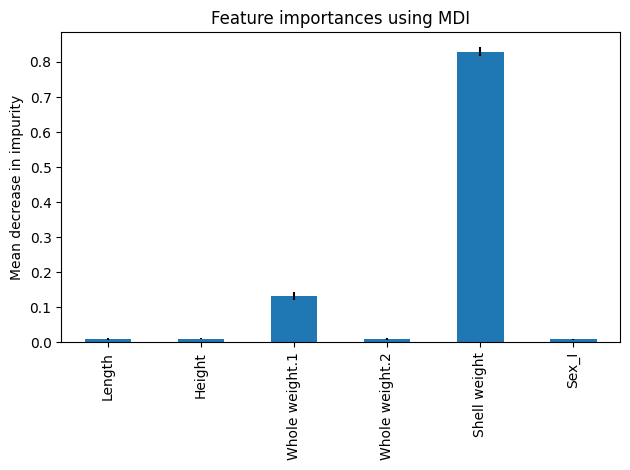

In [9]:
importances = rforest_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in rforest_regressor.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Those with larger *Shell weight* and *Whole weight.1* tend to have more *Rings*.

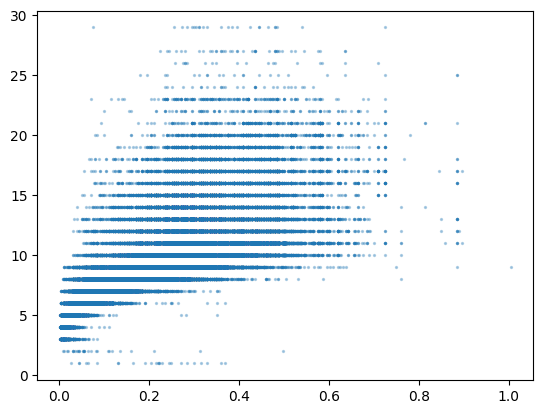

In [10]:
plt.scatter(train_data['Shell weight'],train_data['Rings'], s = 2, alpha = 0.3)

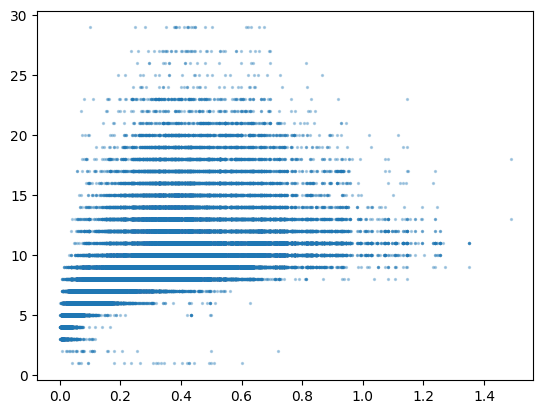

In [11]:
plt.scatter(train_data['Whole weight.1'],train_data['Rings'], s = 2, alpha = 0.3)

The correlation matrix of numerical features suggest that *Length* and *Diamter*, *Whole weight* and *Whole weight.1*, *Whole weight.2* and *Shell weight* are highly correlated.

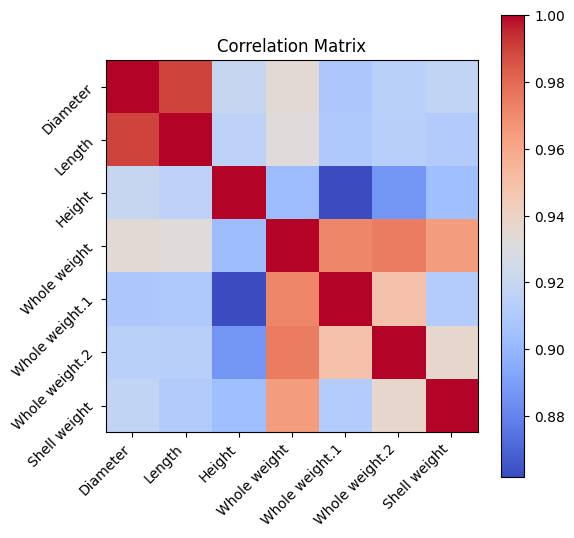

In [12]:
numerical_features = ['Diameter', 'Length','Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
correlation = train_data[numerical_features].corr()
plt.figure(figsize=(6, 6))
plt.imshow(correlation, cmap='coolwarm', interpolation='nearest')
plt.title('Correlation Matrix')
plt.colorbar()
plt.xticks(np.arange(len(numerical_features)), numerical_features, rotation=45, ha='right')
plt.yticks(np.arange(len(numerical_features)), numerical_features, rotation=45, ha='right')
plt.grid(False)
plt.show()

In [13]:
correlation

,Diameter,Length,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
Diameter,1.000000,0.989732,0.919618,0.933848,0.908466,0.914668,0.917871
Length,0.989732,1.000000,0.916094,0.931449,0.909609,0.913134,0.911073
Height,0.919618,0.916094,1.000000,0.902344,0.861769,0.886132,0.904019
Whole weight,0.933848,0.931449,0.902344,1.000000,0.971249,0.974319,0.964201
Whole weight.1,0.908466,0.909609,0.861769,0.971249,1.000000,0.949227,0.911800
Whole weight.2,0.914668,0.913134,0.886132,0.974319,0.949227,1.000000,0.937069
Shell weight,0.917871,0.911073,0.904019,0.964201,0.911800,0.937069,1.000000


Linear Regression <br>
Model 1, features: Sex, Length, Height, Whole weight.1, Whole weight.2, Shell weight, RMSLE: 0.1689 <br>
Model 2, features: Sex, Length, Height, Whole weight.1, Shell weight, RMSLE: 0.1689 <br>
Model 3, features: Sex, Height, Whole weight.1, Shell weight, RMSLE: 0.1689 <br>
Model 4, features: Height, Whole weight.1, Shell weight, RMSLE: 0.1714 <br>

In [14]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_val)
y_pred = y_pred.round().astype(int)
rmsle = root_mean_squared_log_error(y_val,y_pred)
print('RMSLE: ', rmsle)

RMSLE:  0.1688527421198443


In [15]:
y_train_np = y_train.values.astype(float)
X_train_np = X_train.values.astype(float)
X_train_with_const = sm.add_constant(X_train_np)
linear_regression = sm.OLS(y_train_np, X_train_with_const)
model = linear_regression.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 1.593e+04
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:04:14   Log-Likelihood:            -1.3405e+05
No. Observations:               63430   AIC:                         2.681e+05
Df Residuals:                   63423   BIC:                         2.682e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6873      0.071     51.831      0.0

In [16]:
predictions = rforest_regressor.predict(combined_data[len(train_data):])
predictions = predictions.round().astype(int)

In [17]:
output = pd.DataFrame({'id': test_data.id, 'Rings': predictions})
output.to_csv('submission.csv', index=False)